In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel
# from sepObjectiveGO import getObjective as gO
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
from lipidBilayerAsGiven.LipidLeaflet_WaterPer_builtOn3 import LipidLeafletWithWaterPer as LipidLeaflet


print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting
csv
cvs-collecting


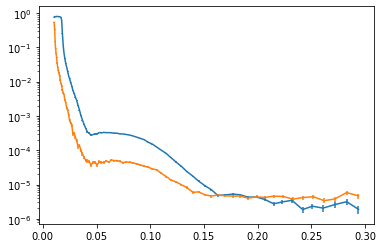

In [2]:
dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
dataD2o.name="d2o"
dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
dataPmw.name="pmw"

plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.yscale("log")
plt.show()

In [3]:
name = "bilayer"

d2o = SLD(6.07, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
air = SLD(0.00, "Air")

d2o.real.setp(vary=True, bounds=(5.35, 6.35))
pmw.real.setp(vary=True, bounds=(1.35, 3.35))


apm = Parameter(value=140, name='%s - area_per_molecule' % name,
                bounds=(100, 180), vary=True) #bounds=(60, 150), vary=True)

#Define all the neutron b's
bc = 0.6646e-4  #Carbon
bo = 0.5804e-4  #Oxygen
bh = -0.3739e-4 #Hydrogen
bp = 0.513e-4   #Phosphorus
bn = 0.936e-4   #Nitrogen
bd = 0.6671e-4  #Deuterium

#Formulae of the molecule sections...
CH2 = (1*bc) + (2*bh)
CH = (1*bc) + (1*bh)
CH3 = (1*bc) + (3*bh)
D2O = (2*bd) + (1*bo)
H2O = (2*bh) + (1*bo)

# Calculate mole fraction of D2O from the bulk SLD..
# d2o_molfr = (1/D2O-H2O)*(contrast*27.64)-H2O
# wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

#sum b's of all the different fragments
b_tails = Parameter(value=(28*CH2) + (2*CH) + (2*CH3),
                       name='%s - b_tails_real' % name)

sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
b_heads = Parameter(value=(3*(sum_popc_heads) + (sum_popg_heads))/4,
                        name='%s - b_heads_real' % name)

#monolayer compositions
#sum_m_tails = (34*CH2) + (2*CH3);
#sum_m_heads = (1*bn) + (2*CH3) + (Waters_per_headD * wMol);

#volumes of each fragment
vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
vm_tails = Parameter(value=(nCH2 * vCH2) + (2 * vCH3),
            name='%s - volume_tails' % name) #
vm_heads = Parameter(value=331,
            name='%s - volume_heads' % name)  #
vm_water = Parameter(value=29.7,
            name='%s - water_vm' % name)

#thickness
thickness_tails = Parameter(6., #value=vm_tails.value/apm.value,
            name='%s - thickness_tails' % name,
            bounds=(3, #(1-0.75)*vm_tails.value/apm.value,
                    9), #(1+0.75)*vm_tails.value/apm.value),
               vary=True)
thickness_heads = Parameter(value= 11., #vm_heads.value/apm.value,
            name='%s - thickness_heads' % name,
            bounds=(9, #(1-0.75)*vm_heads.value/apm.value,
                    15), #(1+0.75)*vm_heads.value/apm.value),
               vary=True)

rough_top = Parameter(value=12.0,
            name='%s - rough_top' % name,
            bounds=(0,20), vary=True)
rough_bot = Parameter(value=10.3,
            name='%s - rough_bot' % name,
            bounds=(0,15), vary=True)

waters_per_head = Parameter(
            value=2.8,
            name="{} - Waters Per Head".format(name),
            bounds=(0, 4), vary=True)
waters_per_tail = Parameter(
            value=0.,
            name="{} - Waters Per Tail".format(name),
            vary=False)


In [4]:
# apm, b_heads, vm_heads, thickness_heads
# b_tails, vm_tails, thickness_tails, rough_head_tail
# rough_preceding_mono, head_solvent


# head_solvent_d2o = SLD(6.07, "D2O in bilayer")
# head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
upper_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    d2o, reverse_monolayer=False, name="upper_lipid_d2o")

lower_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    d2o, reverse_monolayer=True, name="lower_lipid_d2o")


# head_solvent_pmw = SLD(2.35, "Protein Matched Water in bilayer")
# head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
upper_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail, pmw,
    reverse_monolayer=False, name="upper_lipid_pmw")

lower_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail, pmw,
    reverse_monolayer=True, name="lower_lipid_pmw")


In [5]:
# name_m = "mono, dodab"
# APMD = Parameter(value=48, name='%s - area_per_molecule' % name_m,
#         bounds=(30,120), vary=True)

# # monolayer compositions
# m_tails = Parameter(value=(34*CH2) + (2*CH3),
#             name='%s - b_tails_real' % name_m)
# m_heads = Parameter(value=(1*bn) + (2*CH3),
#             name='%s - b_heads_real' % name_m)

# # monolayer volumes
# vm_m_tails = Parameter(value=vCH2*36,
#             name='%s - volume_tails' % name_m)
# vm_m_heads = Parameter(value=54.6,
#             name='%s - volume_heads' % name_m)

# # monolayer thicknesses
# tail_thick_m = Parameter(value=vm_m_tails.value / APMD.value,
#             name='%s - thickness_tails' % name_m,
#             bounds=((1-0.75)*vm_m_tails.value / APMD.value,
#                     (1+0.75)*vm_m_tails.value / APMD.value),
#                vary=True)
# head_thick_m = Parameter(value=vm_m_heads.value / APMD.value,
#             name='%s - thickness heads' % name_m,
#             bounds=((1-0.75)*vm_m_heads.value / APMD.value,
#                     (1+0.75)*vm_m_heads.value / APMD.value),
#                vary=True)

# roughness_m =  Parameter(value=5.8,
#             name='%s - roughness' % name_m,
#             bounds=(0,10), vary=True)


# water_vm_m = Parameter(value=vm_water,
#             name='%s - water_vm' % name_m)
# waters_per_head_m = Parameter(
#             value=2.8,
#             name="{} Waters Per Head".format(name_m),
#             vary=True,
#             bounds=(1, 20))
# waters_per_tail_m = Parameter(
#             value=0.,
#             name="{} Waters Per Tail".format(name_m),
#             vary=False)

In [6]:
# m_head_solvent_pmw=SLD(2.35, "mono, dodab - Protein Matched Water in head")
# m_head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
# m_air_in_tail=SLD(0, "mono, dodab - air in tail")

# dodab_pmw = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
#     thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
#     thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
#     rough_preceding_mono=roughness_m,
#     water_vm=vm_water, waters_per_head=waters_per_head_m,
#     waters_per_tail=waters_per_tail_m,
#     head_solvent=m_head_solvent_pmw, tail_solvent=m_air_in_tail) #mono

# m_head_solvent_d2o=SLD(6.07, "mono, dodab - D2O in head")
# m_head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
# dodab_d2o = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
#     thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
#     thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
#     water_vm=vm_water, waters_per_head=waters_per_head_m,
#     waters_per_tail=waters_per_tail_m,
#     rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_d2o,
#                          tail_solvent=m_air_in_tail) #mono

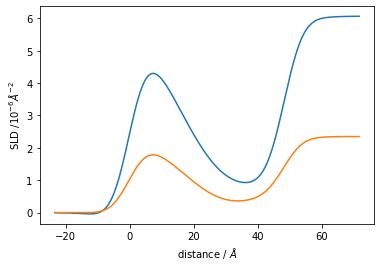

________________________________________________________________________________
Structure:       d2o      
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 20]>
<Parameter:  'D2O - sld'  , value=6.07          , bounds=[5.35, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=4.6          , bounds=[0,

<Parameter:'Protein Matched Water - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>


In [7]:
# structure_d2o = air(0, 0) | dodab_d2o | d2o(0, 0) | upper_lipid_d2o | lower_lipid_d2o | d2o(0, 0)
# structure_pmw = air(0, 0) | dodab_pmw | pmw(0, 0) | upper_lipid_pmw | lower_lipid_pmw | pmw(0, 0)
# structure_d2o = air(0, 0) | d2o(0, 0) | upper_lipid_d2o | lower_lipid_d2o | d2o(0, 0)
# structure_pmw = air(0, 0) | pmw(0, 0) | upper_lipid_pmw | lower_lipid_pmw | pmw(0, 0)
#
#
# solution_thickness = Parameter(value=14.3, bounds=(6, 20), vary=True,
#             name='%s - thickness_solution' % name)

# rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
#             name='%s - rough_preceding_solution' % name)
# 
# structure_d2o[2].thick=solution_thickness#.setp(14.3, vary=True, bounds=(6, 20))
# structure_d2o[2].rough=rough_preceding_solution#.setp(4.6, vary=True, bounds=(3, 20))
# structure_pmw[2].thick=solution_thickness
# structure_pmw[2].rough=rough_preceding_solution
#
# structure_d2o[5].thick=solution_thickness
# structure_d2o[5].rough=rough_preceding_solution
# structure_pmw[5].thick=solution_thickness
# structure_pmw[5].rough=rough_preceding_solution

# to changing to
solution_thickness = Parameter(value=14.3, bounds=(6, 20), vary=True,
            name='thickness_solution')

rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
            name='rough_preceding_solution')

structure_d2o = air(0, 0) | d2o(solution_thickness, rough_preceding_solution) | upper_lipid_d2o | lower_lipid_d2o | d2o(solution_thickness, rough_preceding_solution)
structure_pmw = air(0, 0) | pmw(solution_thickness, rough_preceding_solution) | upper_lipid_pmw | lower_lipid_pmw | pmw(solution_thickness, rough_preceding_solution)

structure_d2o.name = "d2o"
structure_pmw.name = "protein matched water"

plt.plot(*structure_d2o.sld_profile(),label=structure_d2o)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_pmw.sld_profile(),label=structure_pmw)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.show();
print(structure_d2o)
print(structure_pmw)

In [8]:
model1 = ReflectModel(structure_d2o)
model1.scale.setp(1./dataD2o.y.max(), vary=False)
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(dataD2o.y.min() * 0.2, dataD2o.y.min() * 1.8))

model2 = ReflectModel(structure_pmw)
model2.scale.setp(1./dataPmw.y.max(), vary=False)
model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(dataPmw.y.min() * 0.2, dataPmw.y.min() * 1.8))

objective1 = Objective(model1, dataD2o, transform=Transform("logY"))
objective2 = Objective(model2, dataPmw, transform=Transform("logY"))
gobjective = GlobalObjective([objective1,objective2])
choose = 0
if choose==0:
    fitter = CurveFitter(gobjective)
    fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)
if choose==1:
    fitter = CurveFitter(gobjective)
    fitter.sample(400)
    fitter.reset()
    res = fitter.sample(15, nthin=100)
if choose==2:
    from dynesty import DynamicNestedSampler
    from dynesty import plotting as dyplot
    from CFitter import CFitter
    fitter = CFitter(gobjective)
    # DynamicNestedSampler
    DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
    DNSampler.run_nested(dlogz_init=0.05) # was 0.01
    res1 = DNSampler.results

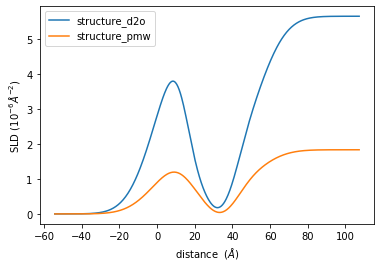

In [9]:
# structure_d2o
# structure_pmw
plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
# structure_d2o.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')
plt.legend()
plt.show();

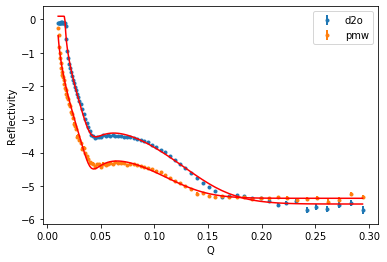

In [10]:
if choose==1:
    gobjective.plot(samples=300)
else:
    gobjective.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

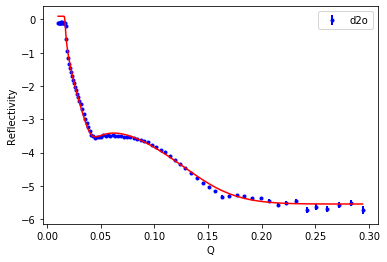

In [11]:
if choose==1:
    objective1.plot(samples=300)
else:
    objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

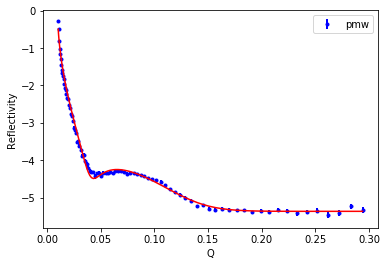

In [12]:
if choose==1:
    objective2.plot(samples=300)
else:
    objective2.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [13]:
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)

model1: d2o <Parameter:    'scale'    , value=1.23916 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=2.84738e-06 +/- 2.23e-07, bounds=[3.72e-07, 3.348e-06]>
model2: pmw <Parameter:    'scale'    , value=1.84843 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=4.2635e-06 +/- 1.33e-07, bounds=[6.74e-07, 6.066e-06]>


In [14]:
print(structure_d2o)

________________________________________________________________________________
Structure:       d2o      
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=15.4524 +/- 2.59 , bounds=[6, 20]>
<Parameter:  'D2O - sld'  , value=5.64063 +/- 0.00347, bounds=[5.35, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=12.3385 +/- 1.03 

In [15]:
print(structure_pmw)

________________________________________________________________________________
Structure: protein matched water
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Protein Matched Water'
<Parameter:'thickness_solution', value=15.4524 +/- 2.59 , bounds=[6, 20]>
<Parameter:'Protein Matched Water - sld', value=1.83047 +/- 0.00436, bounds=[1.35, 3.35]>
<Parameter:'Protein Matched Water - isld', value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_p

In [16]:
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.54523679e+01  5.64063208e+00  0.00000000e+00  1.23384959e+01
   0.00000000e+00]
 [ 1.09126056e+01  1.07520800e+00  5.18654598e-09  5.48619062e+00
   0.00000000e+00]
 [ 7.81805242e+00 -2.54441780e-01  0.00000000e+00  5.48619062e+00
   4.85026247e-03]
 [ 7.81805242e+00 -2.54441780e-01  0.00000000e+00  5.48619062e+00
   4.85026247e-03]
 [ 1.09126056e+01  1.07520800e+00  5.18654598e-09  5.48619062e+00
   0.00000000e+00]
 [ 1.54523679e+01  5.64063208e+00  0.00000000e+00  1.23384959e+01
   0.00000000e+00]]


In [17]:
print(structure_pmw.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.54523679e+01  1.83047303e+00  0.00000000e+00  1.23384959e+01
   0.00000000e+00]
 [ 1.09126056e+01  6.71246851e-01  5.18654598e-09  6.95926079e+00
   0.00000000e+00]
 [ 7.81805242e+00 -2.72922051e-01  0.00000000e+00  6.95926079e+00
   4.85026247e-03]
 [ 7.81805242e+00 -2.72922051e-01  0.00000000e+00  6.95926079e+00
   4.85026247e-03]
 [ 1.09126056e+01  6.71246851e-01  5.18654598e-09  6.95926079e+00
   0.00000000e+00]
 [ 1.54523679e+01  1.83047303e+00  0.00000000e+00  1.23384959e+01
   0.00000000e+00]]


In [18]:
if choose==2:
    # span = [(0,5000),(0,1.5),(0,0.4),(-10**3,10**3)] #span=span
    fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                               logplot=False)

In [19]:
if choose==2:
    print(-min(res1["logvol"])) # ?

In [20]:
#gobjective.varying_parameters()
[[param.name,param.value] for param in gobjective.varying_parameters()]

[['bkg', 2.847381472657008e-06],
 ['thickness_solution', 15.452367929259324],
 ['D2O - sld', 5.640632078668706],
 ['rough_preceding_solution', 12.338495874465469],
 ['bilayer - area_per_molecule', 120.84626598418028],
 ['bilayer - thickness_heads', 10.912605618527111],
 ['bilayer - thickness_tails', 7.818052424919595],
 ['bilayer - rough_top', 5.486190624140487],
 ['bilayer - Waters Per Head', 1.9440308241297026],
 ['bkg', 4.263503108298631e-06],
 ['Protein Matched Water - sld', 1.8304730261673408],
 ['bilayer - rough_bot', 6.959260786712434]]

I believe correct values, leaflet roughness between head and tail is the same as the roughness preceeding the leaflet\
class used is a modified version of the LipidLeaflet class native to refnx, its in the file\
"lipidBilayerAsGiven" and called "LipidLeaflet_WaterPer_builtOn2"\
volumes of head and tails are indirectly varied by changes in waters per head/tail\
so the tails do not change volume\
1 'scale',\
2 'bkg',\
3 'mono, dodab - area_per_molecule',\
4 'mono, dodab - thickness heads',\
5 'mono, dodab - thickness_tails',\
6 'mono, dodab - roughness',\
7 'mono, dodab - D2O in head - sld',\
8 'mono, dodab Waters Per Head',\
9 'D2O - sld',\
10 'bilayer - area_per_molecule',\
11 'bilayer - thickness_heads',\
12 'bilayer - thickness_tails',\
13 'bilayer - rough_top',\
14 'D2O in bilayer - sld',\
15 'bilayer Waters Per Head',\
16 'scale',\
17 'bkg',\
18 'mono, dodab - Protein Matched Water in head - sld',\
19 'Protein Matched Water - sld',\
20 'bilayer - rough_bot',\
21 'Protein Matched Water in bilayer - sld'

In [21]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.traceplot(res1, labels = labels, #truths=np.zeros(fitter.nDim()),
                                 show_titles=True, trace_cmap='plasma',
                                 quantiles=[0.025, 0.5, 0.975])
    fig.tight_layout()

In [22]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.cornerpoints(res1, labels = labels#, #truths=np.zeros(fitter.nDim()),
                                 #show_titles=True,
                                 #trace_cmap='plasma',
                                 #quantiles=[0.025, 0.5, 0.975]
                                   )
    fig.tight_layout()